# 6. Dyna-Q algo

model-based rl vs model-free rl

dyna-q是model-based, 基于模型的，不同于Sarsa和Q-learning

## 6.2. Dyna-Q

伪代码Dyna-Q：
1. 初始化$Q(s, a)$以及模型$M(s, a)$, 
2. **for**  $e = 1 \rightarrow E$ **do**:
   1. 得到初始状态$s$
   2. **for** $t = 1 \rightarrow T$ **do**
      1. $\epsilon$-greedy根据$Q$选择当前$s$的$a$
      2. 得到环境反馈$r, s'$
      3.  $Q(s, a) \leftarrow Q(s, a) + \alpha[r + \gamma \argmax_{a'}Q(s', a') - Q(s, a)]$
      4.  $M(s, a) \leftarrow r, s'$
      5.  **for** $n = 1 \rightarrow N$ **do**:
          1.  随机选择访问过的状态$s_m$
          2.  采取曾在$s_m$下执行过的$a_m$
          3.  $r_m, s_m' \leftarrow M(s_m, a_m)$
          4.  $Q(s_m, a_m) \leftarrow Q(s_m, a_m) + \alpha[r_m + \gamma \argmax_{a'}Q(s'_m, a') - Q(s_m, a_m)]$
      6. **end for**
      7.  $s \leftarrow s'$  
    3. **end for**
3. **end for**

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random
import time

class CliffWalkingEnv:
  def __init__(self, ncol, nrow):
    self.nrow = nrow
    self.ncol = ncol 
    self.x = 0 # 记录当前智能体位置的横坐标
    self.y = self.nrow - 1 # 记录当前智能体位置的纵坐标
    
  def step(self, action): # 外部调用这个函数来改变当前位置
    # 4种动作, change[0]:上, change[1]:下, change[2]:左, change[3]:右。
    # 坐标系原点(0,0), 定义在左上角
    change = [[0, -1], [0, 1], [-1, 0], [1, 0]]
    self.x = min(self.ncol - 1, max(0, self.x + change[action][0]))
    self.y = min(self.nrow - 1, max(0, self.y+ change[action][1]))
    next_state = self.y * self.ncol + self.x
    reward = -1
    done = False
    if self.y == self.nrow - 1 and self.x > 0: # 下一个位置在悬崖或者目标
      done = True
      if self.x != self.ncol - 1:
        reward = -100
    return next_state, reward, done
  
  def reset(self): # 回归初始状态,坐标轴原点在左上角
    self.x = 0
    self.y = self.nrow - 1
    return self.y * self.ncol + self.x

In [6]:
class DynaQ:
  def __init__( self, 
                ncol, nrow, 
                epsilon, alpha, gamma, 
                n_planning, n_action=4
    ):
    self.Q_table = np.zeros([nrow * ncol, n_action]) # 初始化Q(s,a)表格
    self.n_action = n_action # 动作个数
    self.alpha = alpha # 学习率
    self.gamma = gamma # 折扣因子
    self.epsilon = epsilon # 贪婪参数
    
    self.n_planning = n_planning # 执行Q-planning的次数, 对应1次Q-learning
    self.model = dict() # 环境模型
    
  def take_action(self, state): # 选取下一步操作，epsilon贪婪
    if np.random.random() < self.epsilon:
      action = np.random.randint(self.n_action)
    else:
      action = np.argmax(self.Q_table[state])
    return action
  
  def q_learning(self, s0, a0, r, s1):
    td_error = r + self.gamma * self.Q_table[s1].max() - self.Q_table[s0, a0]
    self.Q_table[s0, a0] += self.alpha * td_error
  
  def update(self, s0, a0, r, s1):
    self.q_learning(s0, a0, r, s1)
    self.model[(s0, a0)] = r, s1 # 将数据添加到模型中
    for _ in range(self.n_planning): # Q-planning循环
      # 随机选择曾经遇到过的状态动作对
      (s, a), (r, s_) = random.choice(list(self.model.items()))
      self.q_learning(s, a, r, s_)

In [7]:
def DynaQ_CliffWalking(n_planning):
  ncol = 12
  nrow = 4
  env = CliffWalkingEnv(ncol, nrow)
  epsilon = 0.01
  alpha = 0.1
  gamma = 0.9
  agent = DynaQ(ncol, nrow, epsilon, alpha, gamma, n_planning)
  num_episodes = 300 

  return_list = []
  for i in range(10):
    # tdqm 进度条
    with tqdm(total=int(num_episodes / 10), 
              desc='Iteration %d' % i) as pbar:
      for i_episode in range(int(num_episodes / 10)):
        episode_return = 0
        state = env.reset()
        done = False
        while not done:
          action = agent.take_action(state)
          next_state, reward, done = env.step(action)
          episode_return += reward 
          agent.update(state, action, reward, next_state)
          state = next_state
        return_list.append(episode_return)
        if (i_episode + 1) % 10 == 0: 
          pbar.set_postfix({
            'episode':
            '%d' % (num_episodes / 10 * i + i_episode + 1),
            'return':
            '%.3f' % np.mean(return_list[-10:])
          })
        pbar.update(1)
  return return_list

Q-planning步数为：0


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 3748.93it/s, episode=300, return=-16.500]


Q-planning步数为：2


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 2307.22it/s, episode=300, return=-13.500]


Q-planning步数为：20


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 422.41it/s, episode=300, return=-13.400]


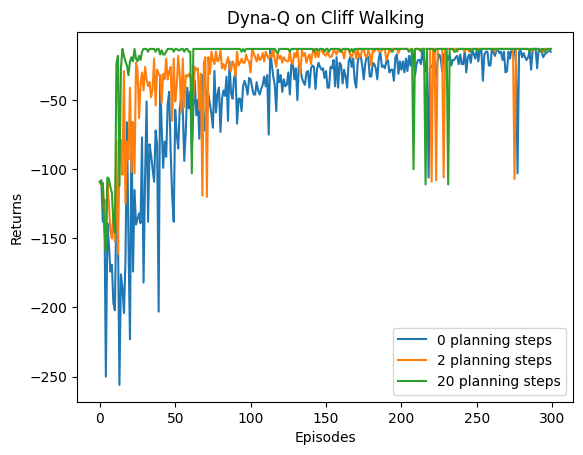

In [9]:
np.random.seed(0)
random.seed(0)
n_planning_list = [0, 2, 20]
for n_planning in n_planning_list:
  print('Q-planning步数为：%d' % n_planning)
  time.sleep(0.5)
  return_list = DynaQ_CliffWalking(n_planning)
  episodes_list = list(range(len(return_list)))
  plt.plot(episodes_list, return_list,
            label=str(n_planning) + ' planning steps')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Dyna-Q on {}'.format('Cliff Walking'))
plt.show()